In [11]:
# import system libs
import os
import time
import random
import pathlib
import itertools
from glob import glob

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

# import Deep learning Libraries
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, SeparableConv2D, GroupNormalization

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [12]:
# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [13]:
def create_gens(df, aug_dict, preprocessing_steps=[]):
    img_size = (256, 256)
    batch_size = 40

    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', 
                                            target_size=img_size, batch_size=batch_size, seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', 
                                           target_size=img_size, batch_size=batch_size, seed=1)

    gen = zip(image_gen, mask_gen)

    for img, msk in gen:
        img = img / 255.0  # Normalize image to [0, 1]
        msk = msk / 255.0  # Normalize mask to [0, 1]
        msk[msk > 0.5] = 1  # Binarize mask
        msk[msk <= 0.5] = 0  

        # Apply preprocessing steps to each image in batch
        for step in preprocessing_steps:
            img, msk = step(img, msk)

        yield (img, msk)


In [14]:
# Z-score normalization
def z_score_norm(img, msk, mean=0.5, std=0.2): 
    img = (img - mean) / std  
    return img, msk

# Histogram Equalization (for contrast enhancement)
def hist_eq(img, msk):
    img_new = np.zeros_like(img)
    for i in range(img.shape[0]):  # Loop through batch
        img_yuv = cv2.cvtColor((img[i] * 255).astype(np.uint8), cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])  # Apply to Y channel
        img_new[i] = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB) / 255.0
    return img_new, msk


# Gaussian Blur (for noise reduction)
def gaussian_blur(img, msk, kernel_size=(5,5)):
    img = np.array([cv2.GaussianBlur(i, kernel_size, 0) for i in img])
    return img, msk


In [15]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder Path
    conv1 = SeparableConv2D(64, (3, 3), padding="same")(inputs)
    conv1 = Activation("relu")(conv1)
    conv1 = SeparableConv2D(64, (3, 3), padding="same")(conv1)
    conv1 = GroupNormalization()(conv1)
    conv1 = Activation("relu")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = SeparableConv2D(128, (3, 3), padding="same")(pool1)
    conv2 = Activation("relu")(conv2)
    conv2 = SeparableConv2D(128, (3, 3), padding="same")(conv2)
    conv2 = GroupNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = SeparableConv2D(256, (3, 3), padding="same")(pool2)
    conv3 = Activation("relu")(conv3)
    conv3 = SeparableConv2D(256, (3, 3), padding="same")(conv3)
    conv3 = GroupNormalization()(conv3)
    conv3 = Activation("relu")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = SeparableConv2D(512, (3, 3), padding="same")(pool3)
    conv4 = Activation("relu")(conv4)
    conv4 = SeparableConv2D(512, (3, 3), padding="same")(conv4)
    conv4 = GroupNormalization()(conv4)
    conv4 = Activation("relu")(conv4)

    # Decoder Path
    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = SeparableConv2D(256, (3, 3), padding="same")(up5)
    conv5 = Activation("relu")(conv5)
    conv5 = SeparableConv2D(256, (3, 3), padding="same")(conv5)
    conv5 = GroupNormalization()(conv5)
    conv5 = Activation("relu")(conv5)

    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = SeparableConv2D(128, (3, 3), padding="same")(up6)
    conv6 = Activation("relu")(conv6)
    conv6 = SeparableConv2D(128, (3, 3), padding="same")(conv6)
    conv6 = GroupNormalization()(conv6)
    conv6 = Activation("relu")(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(conv6)
    up7 = concatenate([up7, conv1])
    conv7 = SeparableConv2D(64, (3, 3), padding="same")(up7)
    conv7 = Activation("relu")(conv7)
    conv7 = SeparableConv2D(64, (3, 3), padding="same")(conv7)
    conv7 = GroupNormalization()(conv7)
    conv7 = Activation("relu")(conv7)

    outputs = SeparableConv2D(1, (1, 1), activation="sigmoid")(conv7)

    return Model(inputs, outputs)

In [16]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [17]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]
        # read image and convert it to RGB scale
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read mask
        mask = cv2.imread(mask_path)
        # sho image and mask
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [18]:
data_dir = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)

print(len(train_df))

tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')


preprocessing_pipeline = [z_score_norm, hist_eq, gaussian_blur]

train_gen = create_gens(train_df, aug_dict=tr_aug_dict, preprocessing_steps=preprocessing_pipeline)
valid_gen = create_gens(valid_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})

#show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

3143


In [19]:
model = unet()

model.compile(optimizer=AdamW(learning_rate=0.001), loss=[dice_loss], metrics=['accuracy', dice_coef, iou_coef])

model.summary()

In [ ]:
epochs = 120
batch_size = 160

# Callbacks
callbacks = [
    ModelCheckpoint('unet.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_df) // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=len(valid_df) // batch_size,
)


Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3681 - dice_coef: 0.0215 - iou_coef: 0.0109 - loss: -0.0215Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_loss improved from inf to -0.01702, saving model to unet.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.3751 - dice_coef: 0.0216 - iou_coef: 0.0109 - loss: -0.0216 - val_accuracy: 0.3546 - val_dice_coef: 0.0170 - val_iou_coef: 0.0086 - val_loss: -0.0170 - learning_rate: 0.0010
Epoch 2/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6989 - dice_coef: 0.0220 - iou_coef: 0.0112 - loss: -0.0220
Epoch 2: val_loss improved from -0.01702 to -0.01721, saving model to unet.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7001 - dice_coef: 0.0221 - iou_coef: 0.0112 - loss: -0.0221 - val_accuracy: 0.3781 - val_dice_coef: 0.0172 - val_iou_coef: 0.0087 - val_loss: -0.0172 - learning_rate

In [21]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train IoU: ", train_score[1])
print("Train Dice: ", train_score[2])
print("Train Accuracy: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid IoU: ", valid_score[1])
print("Valid Dice: ", valid_score[2])
print("Valid Accuracy: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test IoU: ", test_score[1])
print("Test Dice: ", test_score[2])
print("Test Accuracy: ", test_score[3])

131/131 ━━━━━━━━━━━━━━━━━━━━ 108s 831ms/step - accuracy: 0.9871 - dice_coef: 0.3730 - iou_coef: 0.2338 - loss: -0.3735
131/131 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step - accuracy: 0.9899 - dice_coef: 0.4708 - iou_coef: 0.3130 - loss: -0.4707
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 213ms/step - accuracy: 0.9909 - dice_coef: 0.4659 - iou_coef: 0.3099 - loss: -0.4664
Train Loss:  -0.37090742588043213
Train IoU:  0.9866474866867065
Train Dice:  0.37016889452934265
Train Accuracy:  0.23133940994739532
--------------------
Valid Loss:  -0.47166305780410767
Valid IoU:  0.9898496270179749
Valid Dice:  0.4718252718448639
Valid Accuracy:  0.3138556480407715
--------------------
Test Loss:  -0.462022602558136
Test IoU:  0.9909573793411255
Test Dice:  0.4616397023200989
Test Accuracy:  0.3060590624809265


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


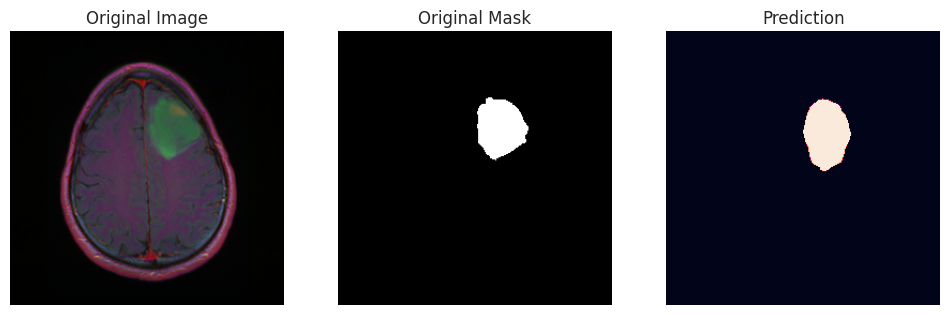

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


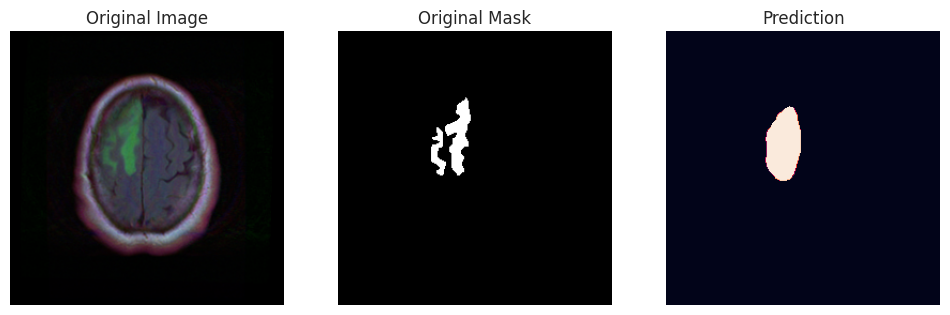

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


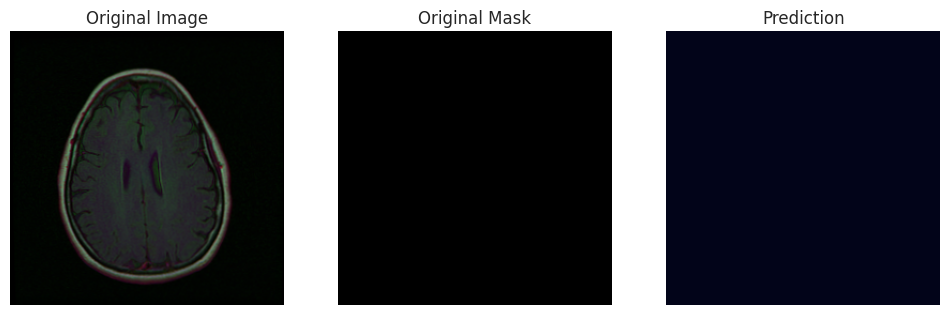

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


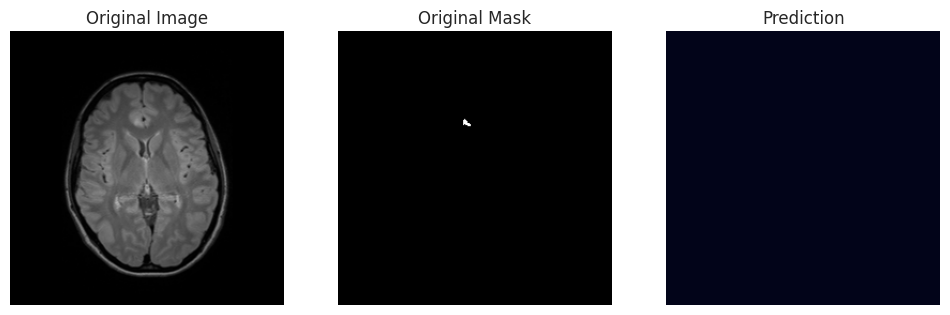

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


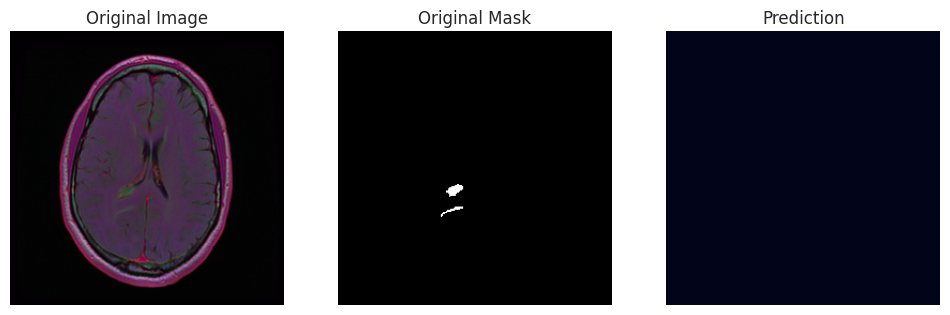

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


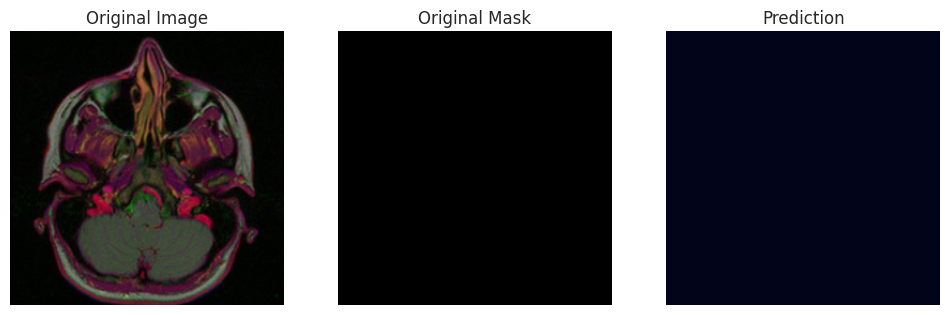

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


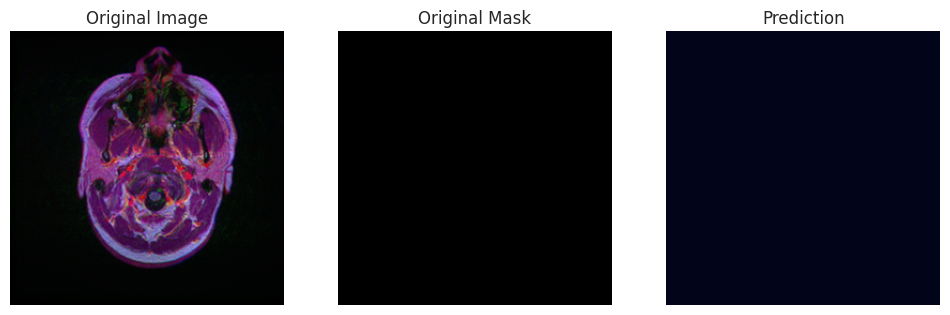

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


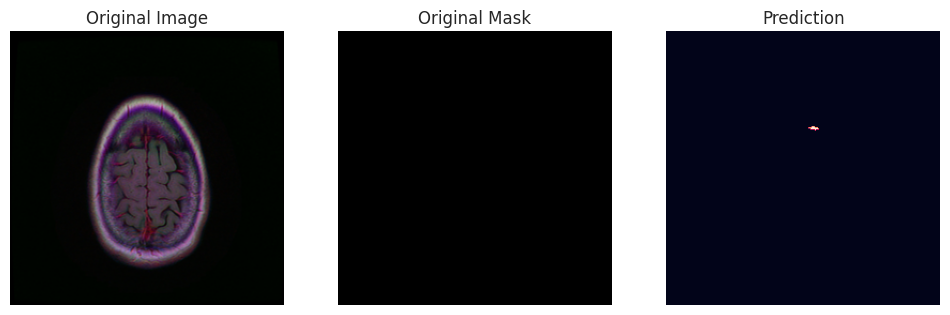

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


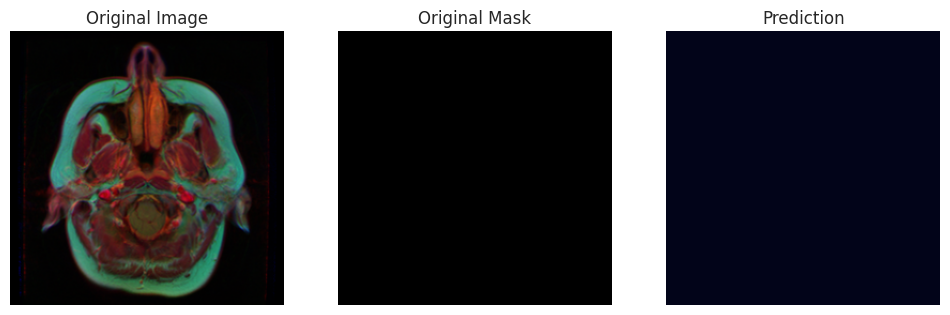

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


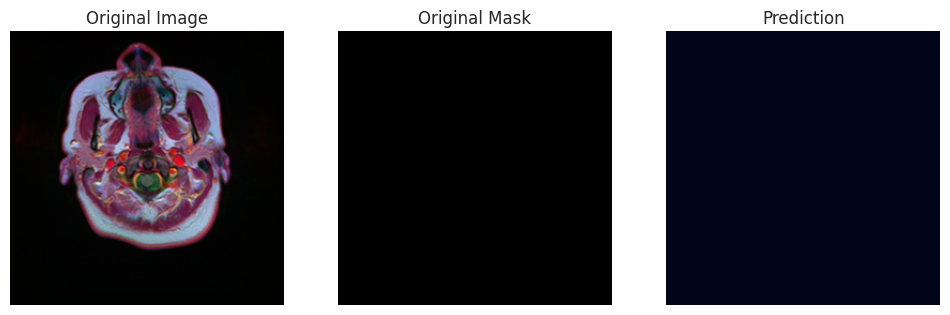

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


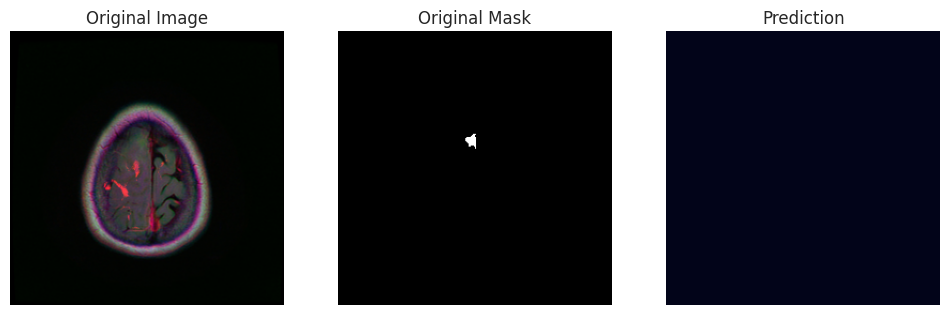

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


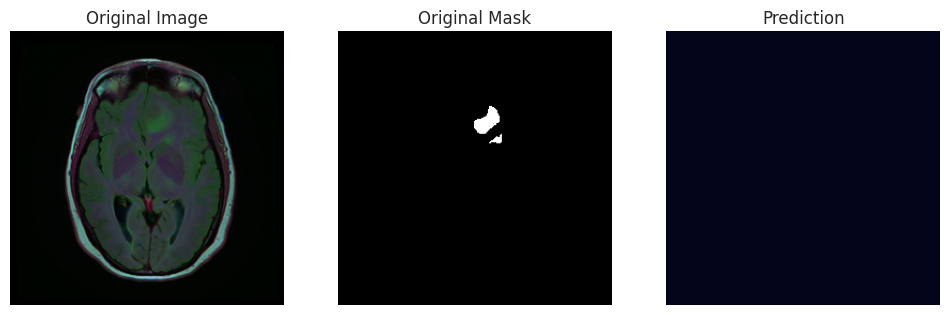

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


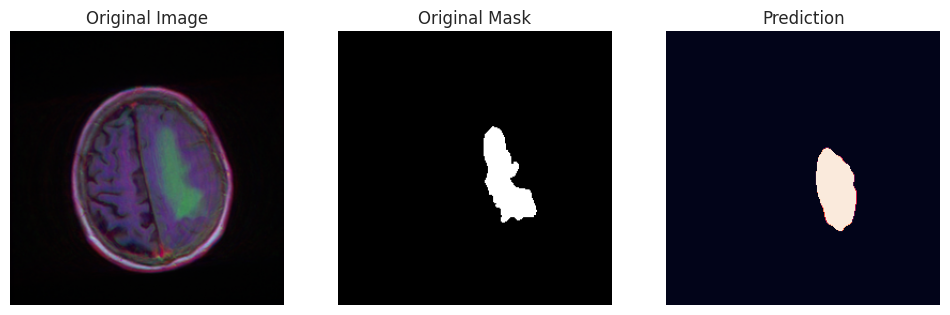

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


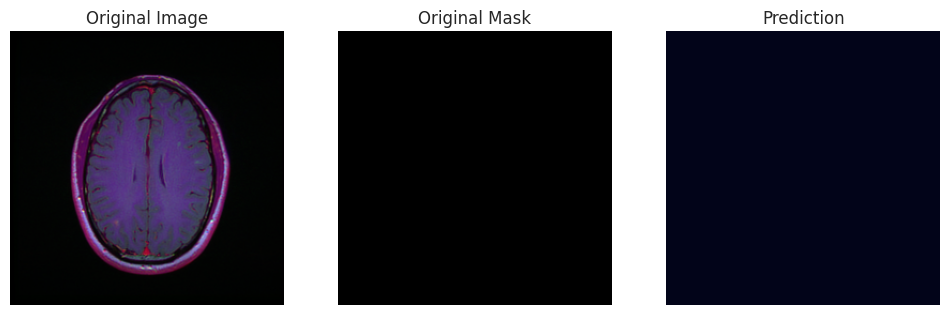

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


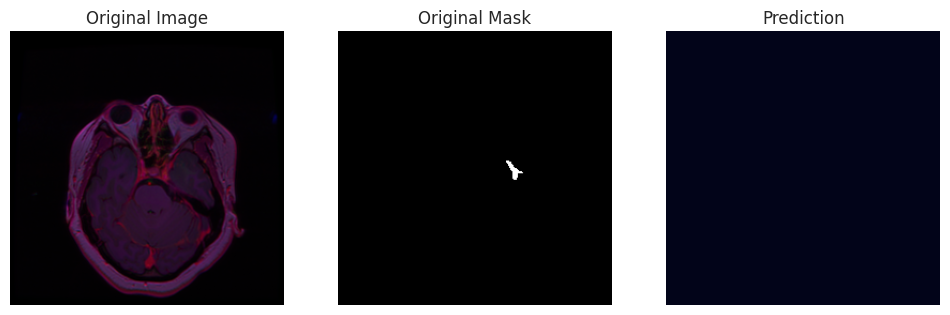

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


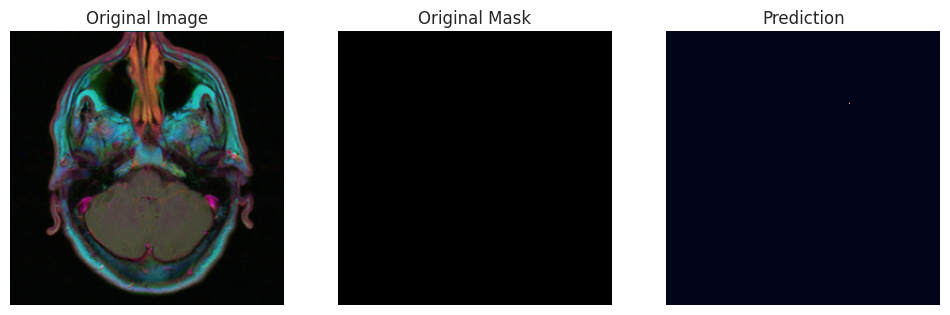

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


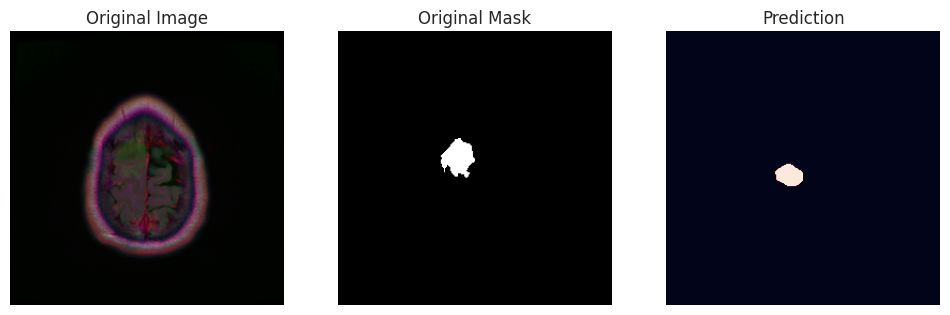

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


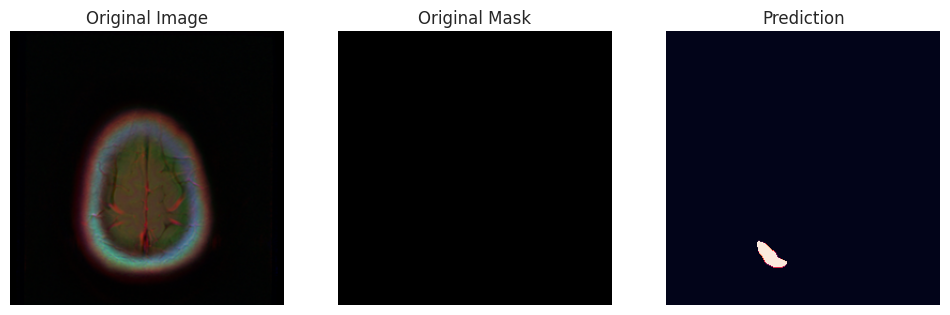

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


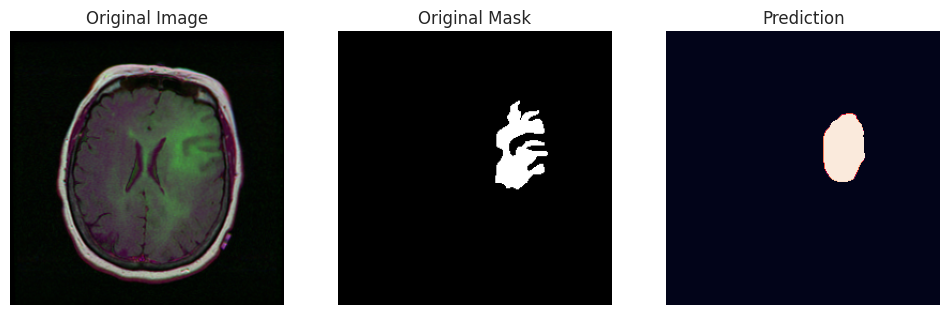

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


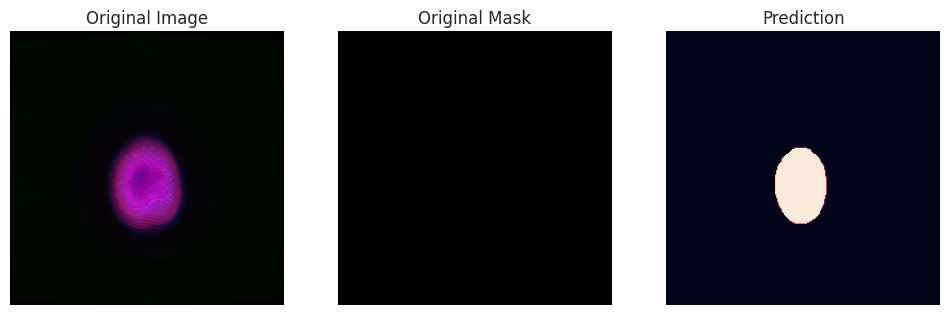

In [22]:
for _ in range(20):
    index = np.random.randint(1, len(test_df.head(2000).index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()